In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as sps
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import qp

In [2]:
# Run Notebook that contains neccessary functions
%run convert_file.ipynb
%run f_nu_models.ipynb


In [3]:
# these things don't change the value because they get cancelled for color (only depends on SED which depends on temperature)
R = (0.185*u.Rsun).cgs.value
d = (10*u.pc).cgs.value
# F_0 in AB system, which is constant
F_0 = (3631.00*u.Jy).cgs.value



Table 3 from CHABRIER+00: https://iopscience.iop.org/article/10.1086/309513/pdf

Text(0, 0.5, '$T_{eff} (K)$')

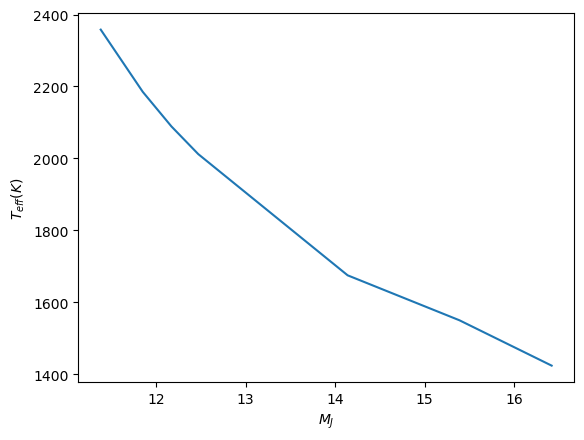

In [5]:
# 0.1 Gyr
# T_eff = np.array([1441, 1878, 2234, 2483, 2576, 2652, 2768, 2787, 2814, 2854, 2920, 2971])
# M_J = np.array([15.68, 12.22, 11.04, 10.47, 10.27, 10.11, 9.83, 9.78, 9.71, 9.61, 9.41, 9.27])
# log_g = np.array([4.53, 4.71, 4.80, 4.84, 4.86, 4.87, 4.88, 4.88, 4.88, 4.89, 4.89, 4.90])

# 1 Gyr
# mass range: 0.05 to 0.08 SM
# M_J range: 11.38 to 16.42
# T_eff range: 1424 to 2358 K
# log(g) range: 5.18 to 5.32 cm/s
T_eff = np.array([1424, 1550, 1675, 2012, 2089, 2185, 2358])
M_J = np.array([16.42, 15.39, 14.14, 12.47, 12.17, 11.85, 11.38])
log_g = np.array([5.18, 5.22, 5.27, 5.32, 5.32, 5.33, 5.32])
sorted_indices = np.argsort(M_J)
sorted_M_J = M_J[sorted_indices]
sorted_T_eff = T_eff[sorted_indices]
sorted_log_g = log_g[sorted_indices]
# Cubic spline of T_eff and log_g as a function of M_J
Teff_spl = InterpolatedUnivariateSpline(sorted_M_J, sorted_T_eff, k=3)
log_g_spl = InterpolatedUnivariateSpline(sorted_M_J, sorted_log_g, k=3)

plt.plot(sorted_M_J, Teff_spl(sorted_M_J))
plt.xlabel(r"$M_J$")
plt.ylabel(r"$T_{eff} (K)$")


Text(0, 0.5, '$log(g)$')

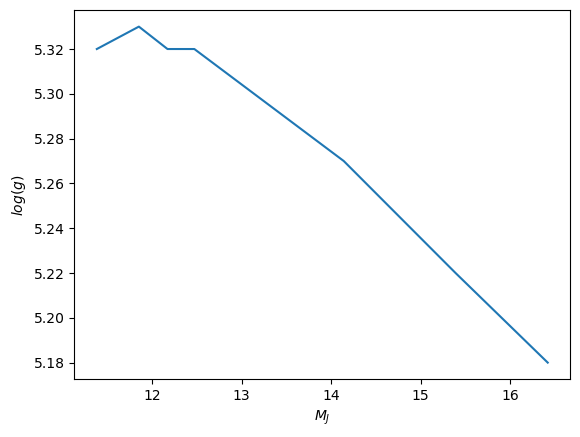

In [6]:
plt.plot(sorted_M_J, log_g_spl(sorted_M_J))
plt.xlabel(r"$M_J$")
plt.ylabel(r"$log(g)$")

# Function for converting histogram to DES passbands #
Shifts edge values and re-normalizes probabilities

In [8]:
def convert_passbands(bin_edges, old_heights, old_bin_width, passband_shift):
    # converted bin edges
    new_bin_edges = bin_edges + passband_shift
    # new "counts" for each bin
    new_heights = old_heights*old_bin_width/(new_bin_edges[1]-new_bin_edges[0])
    return new_bin_edges, new_heights
    

# Trying Sonora model for $T_{eff}=1441K$ #

In [10]:
# Read in Z, Y, r, and i passband files
wavelengths_z, transmission_z = ascii_to_array('CTIO/CTIO_DECam-z.txt')
wavelengths_Y, transmission_Y = ascii_to_array('CTIO/CTIO_DECam.Y.txt')
wavelengths_i, transmission_i = ascii_to_array('CTIO/CTIO_DECam.i.txt')
wavelengths_r, transmission_r = ascii_to_array('CTIO/CTIO_DECam.r.txt')

# For T_eff = 1424K, log(g) = 5.18
filename = 'Sonora Model/sp_t1400g1000nc_m-0.5.txt' 
# Surface flux
f_nu_spl = sonora_to_spline(filename)
# Surface flux in z-band
f_nu_z = passband_flux(f_nu_spl(wavelengths_z.cgs.value), transmission_z, wavelengths_z)
f_nu_Y = passband_flux(f_nu_spl(wavelengths_Y.cgs.value), transmission_Y, wavelengths_Y)
f_nu_i = passband_flux(f_nu_spl(wavelengths_i.cgs.value), transmission_i, wavelengths_i)
f_nu_r = passband_flux(f_nu_spl(wavelengths_r.cgs.value), transmission_r, wavelengths_r)

m_z = get_and_compare_mag(f_nu_z, R, d, F_0)
m_Y = get_and_compare_mag(f_nu_Y, R, d, F_0)
m_i = get_and_compare_mag(f_nu_i, R, d, F_0)
m_r = get_and_compare_mag(f_nu_r, R, d, F_0)

print(f"r-i: {m_r - m_i}")
print(f"i-z: {m_i - m_z}")
print(f"z-Y: {m_z - m_Y}")

r-i: 2.893770909142212
i-z: 3.0871284196913997
z-Y: 0.6417477655755697


# Gets Magnitudes in given passband #

In [12]:
def get_abs_mags(filename):

    # Surface flux
    f_nu_spl = sonora_to_spline(filename)
    # Surface flux in z-band
    f_nu_z = passband_flux(f_nu_spl(wavelengths_z.cgs.value), transmission_z, wavelengths_z)
    f_nu_Y = passband_flux(f_nu_spl(wavelengths_Y.cgs.value), transmission_Y, wavelengths_Y)
    f_nu_i = passband_flux(f_nu_spl(wavelengths_i.cgs.value), transmission_i, wavelengths_i)
    f_nu_r = passband_flux(f_nu_spl(wavelengths_r.cgs.value), transmission_r, wavelengths_r)
    
    m_z = get_and_compare_mag(f_nu_z, R, d, F_0)
    m_Y = get_and_compare_mag(f_nu_Y, R, d, F_0)
    m_i = get_and_compare_mag(f_nu_i, R, d, F_0)
    m_r = get_and_compare_mag(f_nu_r, R, d, F_0)

    # r_i_diff = m_r - m_i
    # i_z_diff = m_i - m_z
    # z_Y_diff = m_z - m_Y

    # print(f"r-i: {r_i_diff}")
    # print(f"i-z: {i_z_diff}")
    # print(f"z-Y: {z_Y_diff}")
    
    # return r_i_diff, i_z_diff, z_Y_diff
    return m_z, m_Y, m_i, m_r
    

# Generalizing Sonora for range of $T_{eff}$ #

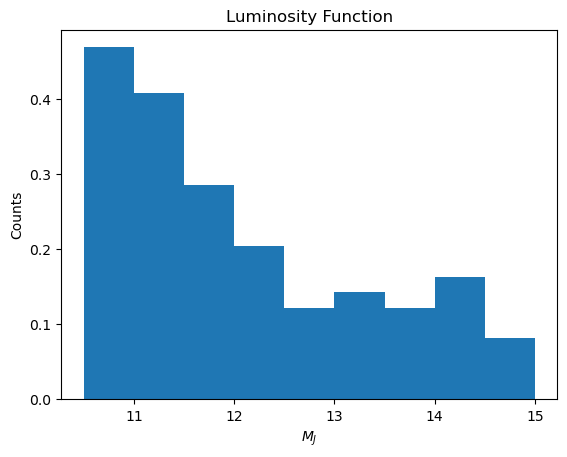

In [14]:
bin_edges = np.linspace(10.5, 15, 10)
counts = np.array([23, 20, 14, 10, 6, 7, 6, 8, 4])
J_bin_width = (bin_edges[1]-bin_edges[0])

midpoints = 0.5*(bin_edges[:-1]+bin_edges[1:])
data = np.repeat(midpoints, counts)
# Normalized weights
M_J_hist = plt.hist(midpoints, bin_edges, weights=counts, range=(0.0, 3.0), density=True)
plt.ylabel("Counts")
plt.xlabel("$M_J$")
plt.title("Luminosity Function")
plt.show()


# Finds the best Sonora model for each $M_J$ where $T_{eff} \leq 2400$ and finds the color magnitudes (uses bin edges) #

In [113]:
T_eff_array, log_g_array, file_dict = create_dict("Sonora Model", "sp_*")
# r_arr, i_arr, z_arr, Y_arr = ([]), ([]), ([]), ([])
r_edges, i_edges, z_edges, Y_edges = ([]), ([]), ([]), ([])

M_J_edges_arr = bin_edges
M_J_edges_arr = np.asarray(M_J_edges_arr)
M_J_arr = 0.5*(M_J_edges_arr[:-1]+M_J_edges_arr[1:])


# for mag_J in M_J_arr :
#     # find corresponding T_eff for M_J
#     T_eff_actual = Teff_spl(mag_J)
#     if T_eff_actual <= 2400:        
#         # find corresponding log_g for M_J
#         log_g_actual = log_g_spl(mag_J)
#         # find nearest value that's used in a Sonora model and returns appropriate model
#         filename = find_file(T_eff_actual, log_g_actual, "Sonora Model", "sp_*")
#         # print(f"T_eff: {np.round(T_eff_actual)} log(g): {log_g_actual}")
#         # print(filename)
#         m_z, m_Y, m_i, m_r = get_abs_mags(filename)

        
#         z_arr.append(m_z)
#         Y_arr.append(m_Y)
#         i_arr.append(m_i)
#         r_arr.append(m_r)
        
for J_edge in M_J_edges_arr:
    T_eff_actual = Teff_spl(J_edge)
    # find corresponding log_g for M_J
    log_g_actual = log_g_spl(J_edge)
    # find nearest value that's used in a Sonora model and returns appropriate model
    filename = find_file(T_eff_actual, log_g_actual, "Sonora Model", "sp_*")
    z_bin_edge, Y_bin_edge, i_bin_edge, r_bin_edge = get_abs_mags(filename)   
   

    z_edges.append(z_bin_edge)
    Y_edges.append(Y_bin_edge)
    i_edges.append(i_bin_edge)
    r_edges.append(r_bin_edge)

# r_arr = np.asarray(r_arr)
# i_arr = np.asarray(i_arr)
# z_arr = np.asarray(z_arr)
# Y_arr = np.asarray(Y_arr)

r_edges = np.asarray(r_edges)
i_edges = np.asarray(i_edges)
z_edges = np.asarray(z_edges)
Y_edges = np.asarray(Y_edges)


indices = np.nonzero(Teff_spl(M_J_arr) <= 2400)
first_edge_index = np.min(indices)
last_edge_index = np.max(indices) + 1
# MAKE EDGES ARRAY 1 MORE THAN LENGTH OF MAGNITUDE/MIDPOINTS ARRAY
M_J_edges_arr = M_J_edges_arr[first_edge_index:last_edge_index+1]
r_edges = r_edges[first_edge_index:last_edge_index+1]
i_edges = i_edges[first_edge_index:last_edge_index+1]
z_edges = z_edges[first_edge_index:last_edge_index+1]
Y_edges = Y_edges[first_edge_index:last_edge_index+1]

# print(r_arr.shape, M_J_arr[Teff_spl(M_J_arr) <= 2400].shape, z_edges.shape, M_J_edges_arr.shape)

# Graph Colors #

r-J = [4.69815021 4.92465469 4.81650757 4.75975969 4.78403932 4.9127287
 4.60493546]
i-J = [2.17731017 2.49413156 2.4193376  2.35785268 2.32768347 2.34626491
 2.00380741]
z-J = [ 0.6243463   0.63201717  0.39684733  0.16078868 -0.07032288 -0.29101642
 -0.63665925]
Y-J = [ 0.33080855  0.28505396  0.01672986 -0.25540276 -0.52927079 -0.80325325
 -1.15743799]


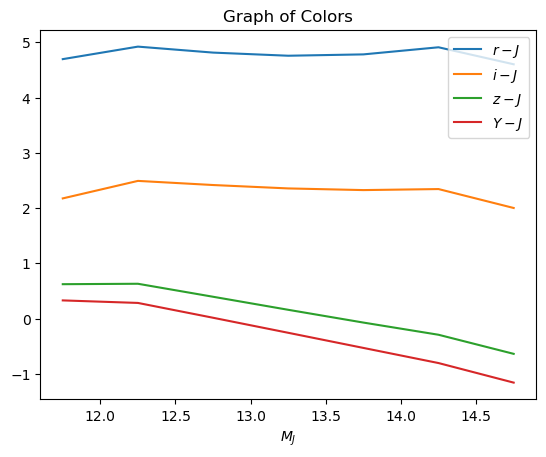

In [147]:
# Midpoints calculated from converted edges in each passband
r_arr = 0.5*(r_edges[1:]+r_edges[:-1])
i_arr = 0.5*(i_edges[1:]+i_edges[:-1])
z_arr = 0.5*(z_edges[1:]+z_edges[:-1])
Y_arr = 0.5*(Y_edges[1:]+Y_edges[:-1])

# Getting the colors
r_J_diff_arr = r_arr - M_J_arr[Teff_spl(M_J_arr) <= 2400]
i_J_diff_arr = i_arr - M_J_arr[Teff_spl(M_J_arr) <= 2400]
z_J_diff_arr = z_arr - M_J_arr[Teff_spl(M_J_arr) <= 2400]
Y_J_diff_arr = Y_arr - M_J_arr[Teff_spl(M_J_arr) <= 2400]

print(f"r-J = {r_J_diff_arr}")
print(f"i-J = {i_J_diff_arr}")
print(f"z-J = {z_J_diff_arr}")
print(f"Y-J = {Y_J_diff_arr}")

# Plotting the colors as function of M_J
plt.plot(M_J_arr[Teff_spl(M_J_arr) <= 2400], r_J_diff_arr, label="$r-J$")
plt.plot(M_J_arr[Teff_spl(M_J_arr) <= 2400], i_J_diff_arr, label="$i-J$")
plt.plot(M_J_arr[Teff_spl(M_J_arr) <= 2400], z_J_diff_arr, label="$z-J$")
plt.plot(M_J_arr[Teff_spl(M_J_arr) <= 2400], Y_J_diff_arr, label="$Y-J$")
plt.legend(loc="best")
plt.xlabel("$M_J$")
# y axis is magnitude differences
plt.title("Graph of Colors")
plt.show()



# Shifts and normalizes the bin_widths with given passband edges #
Returns bin edges to plot and new counts in new passband

In [187]:
def shift_and_normalize(p_edges_arr, counts=counts[Teff_spl(M_J_arr) <= 2400], M_J_edges_arr=M_J_edges_arr[Teff_spl(M_J_edges_arr) <= 2400]):
    # bin widths
    p_bin_widths = p_edges_arr[1:] - p_edges_arr[:-1]
    M_J_bin_widths = M_J_edges_arr[1:] - M_J_edges_arr[:-1]
    new_counts = counts*M_J_bin_widths/p_bin_widths
    
        
    return p_edges_arr, new_counts


Text(0.5, 1.0, 'Luminosity Function Converted to $m_z$ Band')

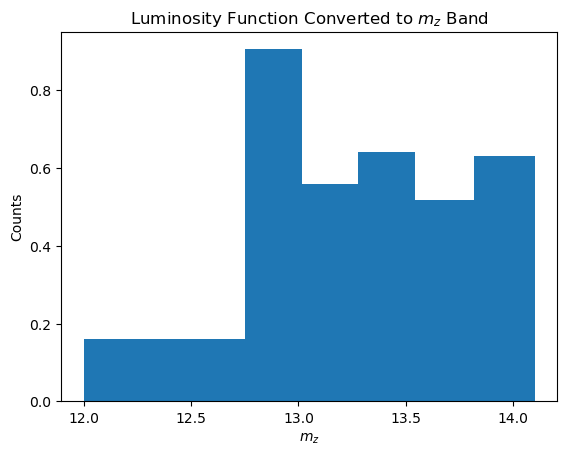

In [199]:
# Can't plot r and i color differences because they don't increase monotonically
r_edges, r_counts = shift_and_normalize(r_edges)
i_edges, i_counts = shift_and_normalize(i_edges)
# z and Y color differences increase monotonically
z_edges, z_counts = shift_and_normalize(z_edges)
Y_edges, Y_counts = shift_and_normalize(Y_edges)

# exclude last points because it is bad (where the color differences relationship breaks because as T_eff increases, the relationship plateaus)
plt.hist(x=z_arr[:-1], bins=z_edges[:-1], weights=z_counts[:-1], density=True)
plt.xlabel("$m_z$")
plt.ylabel("Density")
plt.title("Luminosity Function Converted to $m_z$ Band")

Text(0.5, 1.0, 'Luminosity Function Converted to $m_Y$ Band')

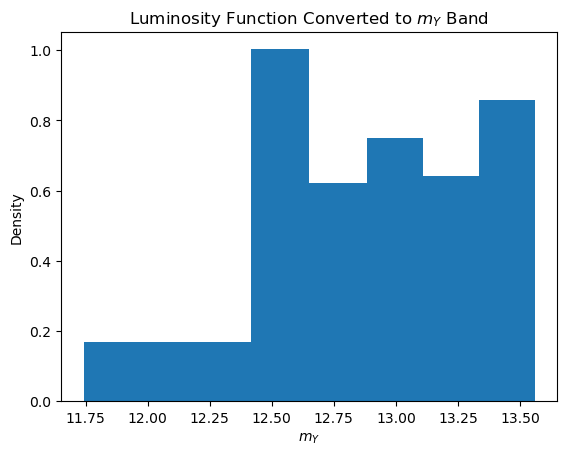

In [201]:
plt.hist(x=Y_arr[:-1], bins=Y_edges[:-1], weights=Y_counts[:-1], density=True)
plt.xlabel("$m_Y$")
plt.ylabel("Density")
plt.title("Luminosity Function Converted to $m_Y$ Band")